# Exercise 4 - Optimization
This exercise focuses on optimization, we will
- implement the Adam optimizer
- compare Adam, SGD, SGD with Momentum
- implement and analyze some learning rate schedules


You can **reuse the code you wrote in the last exercise, or you can use the code we provide (below)**. Just copy the relevant parts into the cell below. Please **note that we extended the `Module` class** with a state to determine whether we're training or evaluating and two functions to toggle this state. We therefore also adapted the training loop function.


### Base classes: `Parameter` and `Module`

In [1]:
from typing import Iterable, List, Optional, Tuple, Callable
import pickle
import gzip

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.optimize

In [2]:
class Parameter:
    """A trainable parameter.

    This class not only stores th_solution-Copy1e value of the parameter but also tensors/
    properties associated with it, such as the gradient of the current backward
    pass.
    """

    def __init__(self, data: np.ndarray, name: Optional[str] = None):
        self.data = data
        self.grad = None
        self.name = name
        self.state_dict = dict()  # dict to store additional, optional information


class Module:
    """The base class all network modules must inherit from."""

    def __init__(self):
        # Cache of the input of the forward pass.
        # We need it during the backward pass in most layers,
        #  e.g., to compute the gradient w.r.t to the weights.
        self.input_cache = None
        self.training = True

    def __call__(self, *args) -> np.ndarray:
        """Alias for forward, convenience function."""
        return self.forward(*args)

    def forward(self, *args) -> np.ndarray:
        """Compute the forward pass through the module.

        Args:
           args: The inputs, e.g., the output of the previous layer.
        """
        raise NotImplementedError

    def backward(self, grad: np.ndarray) -> np.ndarray:
        """Compute the backward pass through the module.

        This method computes the gradients with respect to the trainable
        parameters and with respect to the first input.
        If the module has trainable parameters, this method needs to update
        the respective parameter.grad property.

        Args:
            grad: The gradient of the following layer.

        Returns:
            The gradient with respect to the first input argument. In general
            it might be useful to return the gradients w.r.t. to all inputs, we
            omit this here to keep things simple.
        """
        raise NotImplementedError

    def parameters(self) -> List[Parameter]:
        """Return the module parameters."""
        return []  # default to empty list

    def train(self, mode : bool = True) -> 'Module':
        """Set the module to training mode.

        This only affects some Modules, such as Dropout.
        
        Returns:
            self.
        """
        self.training = mode
        return self

    def eval(self) -> 'Module':
        """Set the module to evaluation mode.

        This only affects some Modules, such as Dropout.

        Returns:
            self.
        """
        return self.train(False)

    def check_gradients(self, input_args: Tuple[np.ndarray]):
        """Verify the implementation of the gradients.

        This includes the gradient with respect to the input as well as the
        gradients w.r.t. the parameters if the module contains any.

        As the scipy grad check only works on scalar functions, we compute
        the sum over the output to obtain a scalar.
        """
        assert isinstance(input_args, tuple), (
            "input_args must be a tuple but is {}".format(type(input_args)))
        TOLERANCE = 1e-6
        self.check_gradients_wrt_input(input_args, TOLERANCE)
        self.check_gradients_wrt_params(input_args, TOLERANCE)

    def _zero_grad(self):
        """(Re-) intialize the param's grads to 0. Helper for grad checking."""
        for p in self.parameters():
            p.grad = np.zeros_like(p.data)

    def check_gradients_wrt_input(self, input_args: Tuple[np.ndarray],
                                  tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. input."""

        def output_given_input(x: np.ndarray):
            """Wrap self.forward for scipy.optimize.check_grad."""
            # we only compute the gradient w.r.t. to the first input arg.
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            return np.sum(self.forward(*args))

        def grad_given_input(x: np.ndarray):
            """Wrap self.backward for scipy.optimize.check_grad."""
            self._zero_grad()
            # run self.forward to store the new input
            args = (x.reshape(input_args[0].shape),) + input_args[1:]
            out = self.forward(*args)
            # compute the gradient w.r.t. to the input
            return np.ravel(self.backward(np.ones_like(out)))

        error = scipy.optimize.check_grad(
            output_given_input, grad_given_input, np.ravel(input_args[0]))
        num_outputs = np.prod(self.forward(*input_args).shape)
        if np.squeeze(error) / num_outputs > tolerance:
            raise RuntimeError("Check of gradient w.r.t. to input for {} failed."
                               "Error {:.4E} > {:.4E}."
                               .format(self, np.squeeze(error), tolerance))

    def check_gradients_wrt_params(self, input_args: Tuple[np.ndarray],
                                   tolerance: float):
        """Verify the implementation of the module's gradient w.r.t. params."""
        for param in self.parameters():
            def output_given_params(new_param: np.ndarray):
                """Wrap self.forward, change the parameters to new_param."""
                param.data = new_param.reshape(param.data.shape)
                return np.sum(self.forward(*input_args))

            def grad_given_params(new_param: np.ndarray):
                self._zero_grad()
                param.data = new_param.reshape(param.data.shape)
                out = self.forward(*input_args)
                # compute the gradient w.r.t. to param
                self.backward(np.ones_like(out))
                return np.ravel(param.grad)
            # flatten the param as scipy can only handle 1D params
            param_init = np.ravel(np.copy(param.data))
            error = scipy.optimize.check_grad(output_given_params,
                                              grad_given_params,
                                              param_init)
            num_outputs = np.prod(self.forward(*input_args).shape)
            if np.squeeze(error) / num_outputs > tolerance:
                raise RuntimeError("Check of gradient w.r.t. to param '{}' for"
                                   "{} failed. Error {:.4E} > {:.4E}."
                                   .format(param.name, self, error, tolerance))



### Activation functions: `Relu` and `Softmax`

In [3]:
class Softmax(Module):

    def forward(self, z: np.ndarray) -> np.ndarray:
        # Shift input for numerical stability.
        reduction_axes = tuple(range(1, len(z.shape)))
        shift_z = z - np.max(z, axis=reduction_axes, keepdims=True)
        exps = np.exp(shift_z)
        h = exps / np.sum(exps, axis=reduction_axes, keepdims=True)
        return h

    def backward(self, grad) -> np.ndarray:
        error_msg = ("Softmax doesn't need to implement a gradient here, as it's"
                     "only needed in CrossEntropyLoss, where we can simplify"
                     "the gradient for the combined expression.")
        raise NotImplementedError(error_msg)


class Relu(Module):

    def forward(self, z: np.ndarray) -> np.ndarray:
        self.input_cache = z
        return np.maximum(0, z)

    def backward(self, grad: np.ndarray) -> np.ndarray:
        z = self.input_cache
        return grad.reshape(z.shape) * np.where(z > 0, 1, 0)

### Layers

In [4]:
class Linear(Module):

    def __init__(self, in_features: int, out_features: int):
        super().__init__()
        self.W = Parameter(np.random.randn(out_features, in_features) * 0.01,
                           name="W")
        self.b = Parameter(np.ones((out_features, 1)) * 0.01, name="b")

    def forward(self, x: np.ndarray) -> np.ndarray:
        assert len(x.shape) == 3, ("x.shape should be (batch_size, input_size, 1)"
                                   " but is {}.".format(x.shape))
        self.input_cache = x
        z = self.W.data @ x + self.b.data
        return z

    def backward(self, grad: np.ndarray) -> np.ndarray:
        x = self.input_cache
        # remember that we have a batch dimension when transposing, i.e.,
        # we need to use np.transpose instead of array.T
        self.W.grad += np.sum(grad @ np.transpose(x, [0, 2, 1]), axis=0)
        self.b.grad += np.sum(grad, axis=0)
        return self.W.data.T @ grad

    def parameters(self) -> List[Parameter]:
        return self.W, self.b


class Sequential(Module):
    """A sequential container to stack modules.

    Modules will be added to it in the order they are passed to the
    constructor.

    Example network with one hidden layer:
    model = Sequential(
                  Linear(5,10),
                  ReLU(),
                  Linear(10,10),
                )
    """
    def __init__(self, *args: List[Module]):
        super().__init__()
        self.modules = args

    def forward(self, x: np.ndarray) -> np.ndarray:
        for module in self.modules:
            x = module(x)  # equivalent to module.forward(x)
        return x

    def backward(self, grad: np.ndarray) -> np.ndarray:
        for module in reversed(self.modules):
            grad = module.backward(grad)
        return grad

    def parameters(self) -> List[Parameter]:
        # iterate over modules and retrieve their parameters, iterate over
        # parameters to flatten the list
        return [param for module in self.modules
                for param in module.parameters()]
    
    def train(self, mode: bool = True) -> 'Sequential':
        """Set the train mode of the Sequential module and it's sub-modules.
        
        This only affects some modules, e.g., Dropout.
        
        Returns:
            self.
        """
        for module in self.modules:
            module.train(mode)
        return self


def one_hot_encoding(y: np.ndarray, num_classes: int) -> np.ndarray:
    """Convert integer labels to one hot encoding.

    Example: y=[1, 2] --> [[0, 1, 0], [0, 0, 2]]
    """
    encoded = np.zeros(y.shape + (num_classes,))
    encoded[np.arange(len(y)), y] = 1
    return encoded

### Optimizers

In [5]:
class Optimizer:
    """The base class for optimizers.

    All optimizers must implement a step() method that updates the parameters.
    The general optimization loop then looks like this:

    for inputs, targets in dataset:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()

    `zero_grad` initializes the gradients of the parameters to zero. This
    allows to accumulate gradients (instead of replacing it) during
    backpropagation, which is e.g. useful for skip connections.
    """

    def __init__(self, params: Iterable[Parameter]):
        """
        Args:
            params: The parameters to be optimized.
        """
        self._params = params

    def step(self) -> None:
        """Update the parameters."""
        raise NotImplementedError

    def zero_grad(self) -> None:
        """Clear the gradients of all optimized parameters."""
        for param in self._params:
            assert isinstance(param, Parameter)
            param.grad = np.zeros_like(param.data)


class SGD(Optimizer):
    """Stochastic Gradient Descent (SGD) optimizer with optional Momentum."""

    def __init__(self, params: Iterable[Parameter], lr: float,
                 momentum: Optional[float] = None):
        super().__init__(params)
        self.lr = lr
        self.momentum = momentum
        if momentum:
            for param in self._params:
                param.state_dict["momentum"] = np.zeros_like(param.data)

    def step(self):
        for p in self._params:
            if self.momentum:
                # update the momentum
                p.state_dict["momentum"] *= self.momentum
                p.state_dict["momentum"] -= self.lr * p.grad
                # update the parameter
                p.data += p.state_dict["momentum"]
            else:
                p.data -= self.lr * p.grad

### Loss Functions


In [6]:
class CrossEntropyLoss(Module):
    """Compute the cross entropy."""

    def __init__(self):
        super().__init__()
        self.softmax = Softmax()

    def forward(self, a: np.ndarray, y: np.ndarray) -> np.ndarray:
        """Compute the cross entropy, mean over batch size."""
        a = self.softmax(a)
        self.input_cache = a, y
        # compute the mean over the batch
        return -np.sum(np.log(a[y == 1])) / len(a)

    def backward(self, _=None) -> np.ndarray:
        # we introduce the argument _ here, to have a unified interface with
        # other Module objects. This simplifies code for gradient checking. 
        # We don't need this arg.
        a, y = self.input_cache
        grad = (a - y) / len(a)

        # We have to recreate the batch dimension
        grad = np.expand_dims(grad, -1)
        return grad

### Training loops

In [7]:
def accuracy(y, predictions, y_is_onehot: bool = False) -> float:
    y_predicted = np.argmax(predictions, axis=-1)
    y = np.argmax(y, axis=-1)
    return np.sum(np.equal(y_predicted, y)) / len(y)


def evaluate(data, labels, model, loss_fn, batch_size):
    predictions = []
    eval_cost = 0.
    data_batched = minibatched(data, batch_size)
    labels_batched = minibatched(labels, batch_size)

    for x, y in zip(data_batched, labels_batched):
        # note that when using cross entropy loss, the softmax is included in the
        # loss and we'd need to apply it manually here to obtain the output as probabilities.
        # However, softmax only rescales the outputs and doesn't change the argmax,
        # so we'll skip this here, as we're only interested in the class prediction.
        h_1 = np.squeeze(model(x))
        predictions.append(h_1)
        eval_cost += loss_fn(h_1, y)
    predictions = np.array(predictions).reshape(-1, 10)
    eval_accuracy = accuracy(y_val, predictions, False)
    return eval_accuracy, eval_cost


def train(model, loss_fn, optimizer, x_train, y_train, x_val, y_val,
          num_epochs, batch_size, scheduler=None):
    train_costs, train_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    eval_costs, eval_accuracies = np.zeros(num_epochs), np.zeros(num_epochs)
    ix = np.arange(len(x_train))
    
    for epoch in range(num_epochs):
        print("Epoch {} / {}:".format(epoch + 1, num_epochs))
        training_predictions = []
        
        np.random.shuffle(ix)
        x_train_batched = minibatched(x_train[ix], batch_size)
        y_train_batched = minibatched(y_train[ix], batch_size)
        
        # train for one epoch
        model.train()
        for x_batch, y_batch in zip(x_train_batched, y_train_batched):
            optimizer.zero_grad()
            y_batch_predicted = model(x_batch)
            h_1 = np.squeeze(y_batch_predicted)
            training_predictions.append(h_1)
            loss = loss_fn(h_1, y_batch)
            grad = loss_fn.backward()
            model.backward(grad)
            optimizer.step()
            train_costs[epoch] += loss
        if scheduler:
            scheduler.step()
        model.eval()
       
        training_predictions = np.array(training_predictions).reshape(-1, 10)
        train_accuracies[epoch] = accuracy(y_train[ix], training_predictions, False)
        print("  Training Accuracy: {:.4f}".format(train_accuracies[epoch]))
        print("  Training Cost: {:.4f}".format(train_costs[epoch]))
        eval_accuracies[epoch], eval_costs[epoch] = evaluate(x_val, y_val, model, loss_fn, batch_size)
        print("  Eval Accuracy: {:.4f}".format(eval_accuracies[epoch]))
    return train_costs, train_accuracies, eval_costs, eval_accuracies

### Data Loading

For this step, you will need the MNIST dataset. You can download it for example from [here](http://deeplearning.net/data/mnist/mnist.pkl.gz). Put it into the same folder as this notebook after downloading. If the link is down and you download it from somewhere else, check if it has 50000 train, 10000 validation and 10000 testing points. Please do not upload this file to your repository.

In [8]:
def load_mnist_data():
    """Loads the data, returns training_data, validation_data, test_data."""
    with gzip.open('mnist.pkl.gz', 'rb') as f:
        return pickle.load(f, encoding='latin1')


def minibatched(data: np.ndarray, batch_size: int) -> List[np.ndarray]:
    assert len(data) % batch_size == 0, ("Data length {} is not multiple of batch size {}"
                                         .format(len(data), batch_size))
    return data.reshape(-1, batch_size, *data.shape[1:])


(x_train, y_train), (x_val, y_val), (x_test, y_test) = load_mnist_data()
x_train = np.expand_dims(x_train, axis=-1)
x_val = np.expand_dims(x_val, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

num_classes = 10
y_train = one_hot_encoding(y_train, num_classes)
y_val = one_hot_encoding(y_val, num_classes)
y_test = one_hot_encoding(y_test, num_classes)

print("Train:\tX {}\ty {}\nVal:\tX {}\ty {}\nTest:\tX {}\ty {}".format(
    x_train.shape, y_train.shape, x_val.shape, y_val.shape,
    x_test.shape, y_test.shape))

Train:	X (50000, 784, 1)	y (50000, 10)
Val:	X (10000, 784, 1)	y (10000, 10)
Test:	X (10000, 784, 1)	y (10000, 10)


## Optimization

<a id='adam'></a>
### Adam
**Implement the step function** of the adam optimizer.

In [9]:
class Adam(Optimizer):

    def __init__(self, params, lr=0.001, betas=(0.9, 0.999), eps=1e-08):
        super().__init__(params)
        # we stick to the pytorch API, the variable names corresponding
        # to the DL book are given in the comments
        self.lr = lr  # lr is called epsilon in the DL book
        self.betas = betas  # betas are called rho in the DL book
        self.eps = eps  # eps is called delta in the DL book
        self.t = 0
        print(self._params)
        for param in self._params:
            # first order moment variables, called m in the paper
            param.state_dict["s"] = np.zeros_like(param.data)
            # second order moment variables, called v in the paper
            param.state_dict["r"] = np.zeros_like(param.data)

    def step(self) -> None:
        """Update the parameters and decaying averages of past gradients."""
        # START TODO ################
        self.t += 1
        for parm in self._params:
            parm.state_dict["s"] = (self.betas[0]*parm.state_dict["s"])+(1-self.betas[0])*parm.grad
            parm.state_dict["r"] = (self.betas[1]*parm.state_dict["r"])+(1-self.betas[1])*(parm.grad)**2
            s_estimate = parm.state_dict["s"]/(1-self.betas[0]**self.t)
            r_estimate = parm.state_dict["r"]/(1-self.betas[1]**self.t)
            delta_ = -(self.lr*s_estimate)/(self.eps+np.sqrt(r_estimate))
            parm.data += delta_
        # END TODO###################


### Compare: Adam vs SGD vs SGD with Momentum

**Train three models** (30 hidden units, relu) for 10 epochs, one with *Adam*, one with *SGD* and one with *SGD with momentum*. 

In [10]:
linear_units = 30
batch_size = 50
num_epochs = 10
sgd_learning_rate = 0.1
momentum = 0.9
adam_learning_rate = 0.01

# START TODO ################
adam_model = Sequential(Linear(x_train.shape[1],linear_units),
                   Relu(),
                   Linear(linear_units,y_train.shape[1]))
adam_loss_fn = CrossEntropyLoss()
adam_optimizer = Adam(adam_model.parameters(),lr=adam_learning_rate)
adam_result = train(adam_model,adam_loss_fn,adam_optimizer,x_train,y_train,x_val,y_val,num_epochs,batch_size,None)
SGD_model = Sequential(Linear(x_train.shape[1],linear_units),
                   Relu(),
                   Linear(linear_units,y_train.shape[1]))
SGD_loss_fn = CrossEntropyLoss()
SGD_optimizer = SGD(SGD_model.parameters(),lr=sgd_learning_rate)
SGD_result = train(SGD_model,SGD_loss_fn,SGD_optimizer,x_train,y_train,x_val,y_val,num_epochs,batch_size,None)
SGD_m_model = Sequential(Linear(x_train.shape[1],linear_units),
                   Relu(),
                   Linear(linear_units,y_train.shape[1]))
SGD_m_loss_fn = CrossEntropyLoss()
SGD_m_optimizer = SGD(params=SGD_m_model.parameters(),lr=sgd_learning_rate,momentum=momentum)
SGD_m_result = train(SGD_m_model,SGD_m_loss_fn,SGD_m_optimizer,x_train,y_train,x_val,y_val,num_epochs,batch_size,None)
# END TODO###################

[<__main__.Parameter object at 0x00000128FF17A048>, <__main__.Parameter object at 0x00000128FF147588>, <__main__.Parameter object at 0x00000128FF1473C8>, <__main__.Parameter object at 0x00000128FF16D198>]
Epoch 1 / 10:
  Training Accuracy: 0.9103
  Training Cost: 294.8191
  Eval Accuracy: 0.9534
Epoch 2 / 10:
  Training Accuracy: 0.9482
  Training Cost: 170.9168
  Eval Accuracy: 0.9516
Epoch 3 / 10:
  Training Accuracy: 0.9561
  Training Cost: 147.8328
  Eval Accuracy: 0.9570
Epoch 4 / 10:
  Training Accuracy: 0.9611
  Training Cost: 131.5311
  Eval Accuracy: 0.9602
Epoch 5 / 10:
  Training Accuracy: 0.9623
  Training Cost: 124.3944
  Eval Accuracy: 0.9602
Epoch 6 / 10:
  Training Accuracy: 0.9658
  Training Cost: 114.3376
  Eval Accuracy: 0.9584
Epoch 7 / 10:
  Training Accuracy: 0.9656
  Training Cost: 116.1764
  Eval Accuracy: 0.9603
Epoch 8 / 10:
  Training Accuracy: 0.9673
  Training Cost: 111.1202
  Eval Accuracy: 0.9583
Epoch 9 / 10:
  Training Accuracy: 0.9701
  Training Cost: 

**Create two plots**, one for the training loss curves and one for the training accuracies curves.

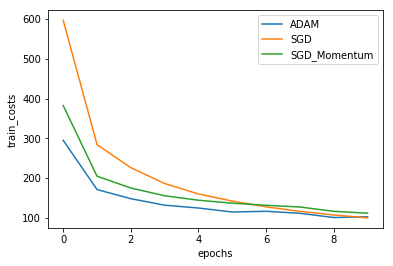

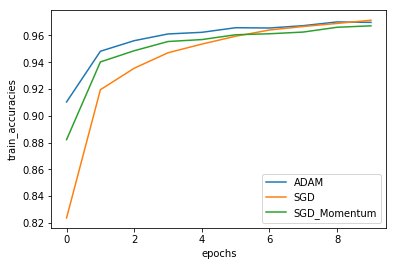

In [11]:
import matplotlib.pyplot as plt 
%matplotlib inline

# START TODO ################
optimizers = [adam_result,SGD_result,SGD_m_result]
legends = ["ADAM","SGD","SGD_Momentum"]
for opti,leg in zip(optimizers,legends):
    t_costs, t_accuracies, ev_costs, ev_accuracies = opti
    plt.plot(t_costs,label=leg)
plt.xlabel("epochs")
plt.ylabel("train_costs")
plt.legend()
plt.show()    
for opti,leg in zip(optimizers,legends):
    t_costs, t_accuracies, ev_costs, ev_accuracies = opti    
    plt.plot(t_accuracies,label=leg)
plt.xlabel("epochs")
plt.ylabel("train_accuracies")
plt.legend()
plt.show()    
# END TODO###################D

### Learning Rate Schedules

Decreasing the learning rate can improve performance of the model.

Pytorch implements learning rate schedules as wrappers for the optimizer and requires the user to call scheduler.step() after each epoch. (We've already done this for you in the training loop above)

**Implement the learning rate scheduler** `PieceWiseConstantLR` and `CosineAnnealingLR`. You can use the provided `LambdaLR` class for this, which works analogously to the pytorch [LambdaLR](https://pytorch.org/docs/master/optim.html#torch.optim.lr_scheduler.LambdaLR)


In [102]:
class LambdaLR:

    def __init__(self, optimizer: Optimizer, lr_lambda: Callable[[int], float]):
        """Sets the learning rate to the initial lr times a given function.

        Args:
            optimizer: The optimzier to wrap.
            lr_lambda: A function that takes the current epoch as an argument
                and returns the corresponding learning rate.
        """
        if not isinstance(optimizer, Optimizer):
            raise TypeError('{} is not an Optimizer'.format(
                type(optimizer).__name__))
        self.optimizer = optimizer
        self.last_epoch = 0
        self.initial_lr = np.copy(optimizer.lr)
        self.lr_lambda = lr_lambda

    def step(self):
        """To be called after each epoch. Update optimizer.lr"""
        self.last_epoch += 1
        self.optimizer.lr = self.lr_lambda(self.last_epoch)


class PiecewiseConstantLR(LambdaLR):

    def __init__(self, optimizer: Optimizer, epochs: List[int],
                 learning_rates: List[float]):
        """Set learning rate as piecewise constant steps.

        This class inherits from LambdaLR and implements the lambda
        function that maps the current epoch to the learning rate
        according to epochs.
        
        optimizer: The optimizer to wrap
        """
        # START TODO ################
        self.epochs = epochs 
        self.learning_rates = [optimizer.lr]+learning_rates 
        super().__init__(optimizer,self.step2())
        # End TODO ################
    
    def step2(self):
        def step2_in(epoch):
            last = 1
            for i,e in enumerate(self.epochs):
                if(e>=epoch):
                    return last*self.learning_rates[i]
                last *= self.learning_rates[i]
        return step2_in            
class CosineAnnealingLR(LambdaLR):

    def __init__(self, optimizer: Optimizer, T_max: int):
        """Set learning rate as a cosine decay.

        This class inherits from LambdaLR and implements the lambda
        function that maps the current epoch to the learning rate
        according to epochs.
        
        optimizer: The optimizer to wrap
        T_max:  Maximum number of epochs.
        """
        # START TODO ################
        super().__init__(optimizer,self.cosine_decay())
        self.T_max = T_max
        self.initial_lr = self.optimizer.lr
    def cosine_decay(self):
        def cosine_decay_in(epoch):
            return 0.5 * (1 + np.cos(epoch / self.T_max * np.pi)) * self.initial_lr    
            return 0.5(1+np.cos((epoch/self.T_max)*np.pi))*self.initial_lr
        return cosine_decay_in
        # End TODO ################

To verify your implementation, **plot the learning rate schedules**, with the number of epochs on the x-axis and the learning rate on the y-axis.

[]
[]


Text(0, 0.5, 'lr')

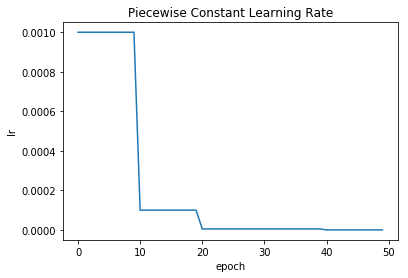

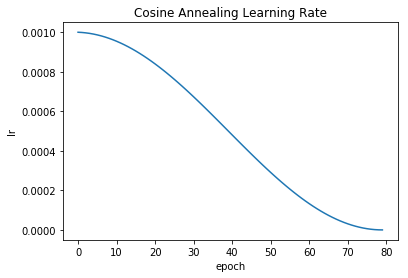

In [103]:
num_epochs = 80

optimizer = Adam([])
picewise_scheduler = PiecewiseConstantLR(optimizer, [10, 20, 40, 50], [0.1, 0.05, 0.01, 0.001])

optimizer = Adam([])
cosine_scheduler = CosineAnnealingLR(optimizer, num_epochs)

# START TODO ################
lrs_picewise = []
lrs_cosine = []
for i in range(num_epochs):
    picewise_scheduler.step()
    lrs_picewise.append(picewise_scheduler.optimizer.lr)
    cosine_scheduler.step()
    lrs_cosine.append(cosine_scheduler.optimizer.lr)
x = range(num_epochs)
plt.figure(1)
plt.plot(x,lrs_picewise)
plt.title('Piecewise Constant Learning Rate')
plt.xlabel('epoch')
plt.ylabel('lr')
plt.figure(2)
plt.plot(x,lrs_cosine)
plt.title('Cosine Annealing Learning Rate')
plt.xlabel('epoch')
plt.ylabel('lr')
# End TODO ################

### Your Feedback on Exercise 4

TODO

We're not sure about the PiecewiseConstantLR implementation. I've asked Boah today in the session and he has told me that we should for first 10 epochs use the initial learning rate and then from 10 to 20 we'll multiply the learning rate that given with the last learning rate which's in this case the initial learning rate and then from 20 to 40 we shall multiply by the corresponding learning rate in the list with the last result and so on.

The first implementation that I've implemented for this task was just return the learning rate corresponding to each range of epochs. but in that implementation is it okay to start with a learning rate (0.001) which's smaller than next learning rate which's 0.1? Is it okay to do so? I mean the list has been ordered in decreasing order so, does it make sense that we implement it that way? 